# Main Model for Handwritten Text Synthesis GAN

This model will consist of 4 major networks, following the general architecture of an GAN.

1. Encoder: Produces an embedding that will be concatenated with the noise vector.
2. Generator: Taking noise vector as input and the text embedding to produce an 128x2048 image.
3. Discriminator: Trained alternating with generator input and ground-truth input, binary classification real or fake.
4. Recognizer: Taking image as input, produce a vector representation of the text.

## Import the required libraries:

In [60]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize

## Data Loading

'A|MOVE|to|stop|Mr.|Gaitskell|from|nominating'

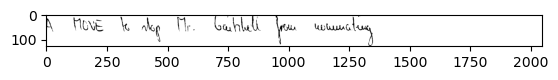

In [88]:
class LineData():
    def __init__(self, image_name, image_path, height, width, graylevel_lim, transcription):
        self.image_name = image_name
        self.image_path = image_path
        # Add a reason for threshold (theres bounding boxes)
        # TODO progress report asks for statistics on the data, record this
        # - average length, max lenth, shortest length, 
        # TODO Remember to explain: why we choose to only use lines (becaues their legnths are pretty consistent)
        # our model doesn' thave to begin at the starts of a sentence
        self.graylevel_lim = graylevel_lim
        self.transcription = transcription

class LineDataset(Dataset):
    def __init__(self, lines_dir, lines_label_dir):
        self.lines_dir = lines_dir
        self.lines_info = []  # List containing the stuff in `lines.txt`

        # Loop through `lines.txt`
        with open(lines_label_dir, "r") as f:
            i = 0
            for line in f.readlines():
                if line.startswith("#"):
                    continue

                # Valid line, not the intro text
                line_items = line.strip().split(" ")  # strip() to remove newlines

                # The actual items (we extract the important ones)
                image_name = line_items[0]
                status = line_items[1]
                graylevel_lim = int(line_items[2])  # For binarize thresholding (actual legends for providing this)
                transcription = line_items[-1]

                # Skip error ones
                if status == "err":
                    continue

                # Alphanumeric + common punctuation
                # Returns None if no match
                # 26 + 26 + 10 + 9 + 1 = 72
                if re.fullmatch("[a-zA-Z0-9.!?'\",:;|-]*", transcription) is None:
                    continue

                # Now we have a valid line
                # And we can get the `.png` image path
                # Assume the root is the directory for `lines/`
                inp = image_name.split("-")  # `inp` stands for image name parts
                # TODO maybe use os.path.join
                image_path = os.path.join(lines_dir, f"{inp[0]}/{inp[0]}-{inp[1]}/{image_name}.png")
                tmp_image = read_image(image_path)  # Temporary image to get the size of it
                _, height, width = tmp_image.shape  # width is the longer one (along x axis)

                # Doing some calculations for scaling
                factor = 128/height
                if width * factor >= 2048:
                    continue

                # Now we have an image that can be scaled into a valid size

                LineData_obj = LineData(image_name, image_path, height, width, graylevel_lim, transcription)
                self.lines_info.append(LineData_obj)
    
    def __len__(self):
        return len(self.lines_info)
    
    def __getitem__(self, index):
        LineData_obj = self.lines_info[index]

        # Get the image
        # TODO change datatype
        image_tensor = read_image(LineData_obj.image_path)

        # Grayscale the image - if the image is not already in grayscale
        grayscale_transform = Grayscale()
        grayscale_image = grayscale_transform(image_tensor)

        # Threshold it
        treshold_image = grayscale_image >= LineData_obj.graylevel_lim

        # Resize it
        resize_transform = Resize(128)
        resized_image = resize_transform(treshold_image)

        # Add padding
        _, _, resized_height = resized_image.shape
        padding_to_add = 2048 - resized_height
        resized_image = F.pad(resized_image, (0, padding_to_add), value=1)
        
        # Return the image and its label
        return resized_image.squeeze(0), LineData_obj.transcription

# TODO save the tensor as a file so we do'nt have to process every time
# saving the final processed tensor 
# use int8 as the datatype


# TODO separate dataloader for images and text

In [95]:
line_dataset = LineDataset(lines_dir="./data/lines/", lines_label_dir="./data/lines.txt")
line_dataloader = DataLoader(line_dataset, batch_size=16, shuffle=True)

'that|girl|who|said|hullo|to|him|in|the|garden|?'

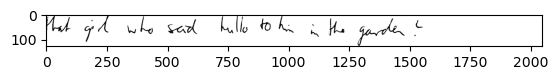

In [94]:
image, label = line_dataset[-1]
plt.imshow(image, cmap='gray')
label

Define Key Functions

In [ ]:
"""Dataloading Functions"""
"""Noise Functions"""
"""Training Functions"""
"""Evaluation Functions"""
"""Plotting Functions"""

## Define Network Classes

### Generator Network Modules

In [ ]:
class ConditionalBatchNorm2d(nn.Module):
    """
    Input: (N, C, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, C, H, W)

    Conditional Batch Normalization
    Idea obtained from https://arxiv.org/pdf/1809.11096.pdf
    This is a network layer that applies batch normalization to the input tensor, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and applies batch normalization to the input tensor. 
    Then it computes 2 affine parameters (scale and bias) for each channel of the input tensor, conditioned on the condition vector through a linear layer.
    The affine parameters are then applied to the input tensor, and the output is returned.
    """
    def __init__(self, in_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        num_conditions: length of the condition vector
        """
        super(ConditionalBatchNorm2d, self).__init__()
        self.in_channels = in_channels

        # batch normalize the input, without using affine parameters
        self.batch_norm = nn.BatchNorm2d(in_channels, affine=False)

        # set up affine parameters conditioned on the condition vector
        self.embed_conditions = nn.Sequential(
            # 512 hidden units are used by https://arxiv.org/pdf/1903.00277.pdf
            nn.Linear(num_conditions, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, in_channels * 2)
        )

        # https://arxiv.org/pdf/1809.11096.pdf
        # initialize affine parameters to be all zeros for bias and ones for scale
        self.embed_conditions.weight.data.zero_()
        self.embed_conditions.bias.data[:in_channels] = 1

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # apply batch normalization, out still has shape (N, C, H, W)
        out = self.batch_norm(x)

        # compute affine parameters
        params = self.embed_conditions(conditions)
        # params has shape (N, 2 * C), we split the channel dimension in half into 2 tensors of shape (N, C)
        scale, bias = params.chunk(2, dim=1)

        # apply scale and bias. every channel's values are scaled and biased by the channel's own scale and bias value
        out = scale.view(-1, self.in_channels, 1, 1) * out + bias.view(-1, self.in_channels, 1, 1)

        # out has shape (N, C, H, W)
        return out
    
class ResBlockUp(nn.Module):
    """
    Input: (N, in_channels, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, out_channels, H * 2, W * 2)

    Residual Block for Upsampling
    Idea obtained from https://arxiv.org/pdf/1903.00277.pdf
    This is a network layer that upsamples the input tensor by a factor of 2, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and upsamples the input tensor by a factor of 2, accounting for the condition vector.
    """
    def __init__(self, in_channels, out_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor
        num_conditions: length of the condition vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockUp, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.relu = nn.ReLU(inplace=True)

        self.batch_norm1 = ConditionalBatchNorm2d(out_channels, num_conditions)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.batch_norm2 = ConditionalBatchNorm2d(out_channels, num_conditions)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)

        if in_channels != out_channels:
            self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.conv1x1 = None

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # upsample the input tensor
        out1 = self.upsample(x)
        # depending on if this res_block_up changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x, conditions)
        out2 = self.relu(out2)
        out2 = self.upsample(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2, conditions)
        out2 = self.relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, 2 * H, 2 * W)
        out = out1 + out2
        return out
    
class SelfAttention(nn.Module):
    """
    TODO: this should be the correct implementation of self-attention, but I am not sure if it is correct. Will check later.
    
    A support layer for the Generator network. Used to help the Generator learn to generate images with more realistic details.
    Idea obtained from: https://arxiv.org/pdf/1805.08318.pdf
    """
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        # f
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1, bias=False)
        # g
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1, bias=False)
        # h
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # get the shape of the input tensor
        N, C, H, W = x.size()

        # get the query, key, and value tensors
        query = self.query_conv(x).view(N, -1, H * W).permute(0, 2, 1)
        key = self.key_conv(x).view(N, -1, H * W)
        value = self.value_conv(x).view(N, -1, H * W)

        # compute the attention map
        attention = torch.bmm(query, key)
        attention = self.softmax(attention)

        # compute the output
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(N, C, H, W)
        out = self.gamma * out + x

        # out has shape (N, C, H, W)
        return out

### Discriminator Network Modules

In [ ]:
class ResBlockDown(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockDown, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.average_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)

        if in_channels != out_channels:
            self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        out1 = self.average_pool(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        out2 = self.average_pool(out2)
        
        # the output has shape (N, out_channels, H / 2, W / 2)
        out = out1 + out2
        return out
    
class ResBlock(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlock, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)

        if in_channels != out_channels:
            self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, H, W)
        out = out1 + out2
        return out
    
class GlobalSumPooling(nn.Module):
    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)

        returns a tensor of shape (N, C)
        """
        return torch.sum(x, dim=(2, 3))

### Define Main Networks

In [ ]:
class Encoder(nn.Module):
    """
    RNN
    Input with a vector representation of an ascii text
    Output a vector embedding of the text
    Purpose is to produce an embedding of the text that includes the relationship between the characters
    """
    pass

class Generator(nn.Module):
    """
    Transposed CNN
    Input with a vector embedding of the text and a noise vector
    Output a 128 x 2048 grayscale image
    Purpose is to produce an image that is a representation of the text, with the noise vector adding some variation
    """

    def __init__(self, noise_dim, embedding_dim):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 8
        embedding_dim: dimension of the embedding vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Generator, self).__init__()

        # We are likely going to need to use 7 ResBlockUp layers to get the image to the desired size of 128 x 2048
        # We will upscale to this from a 1 x 16 tensor
        # 7 ResBlockUp also mean our noise vector will be split into 8 parts. 
        self.noise_chunk_size = noise_dim // 8
        self.embedding_dim = embedding_dim
        self.fc = nn.Linear(self.noise_chunk_size, 256 * 1 * 16)
        self.res_block_up1 = ResBlockUp(256, 256, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up2 = ResBlockUp(256, 128, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up3 = ResBlockUp(128, 128, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up4 = ResBlockUp(128, 64, self.embedding_dim + self.noise_chunk_size)
        self.self_attention = SelfAttention(64)
        self.res_block_up5 = ResBlockUp(64, 32, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up6 = ResBlockUp(32, 16, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up7 = ResBlockUp(16, 16, self.embedding_dim + self.noise_chunk_size)
        self.batch_norm = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, noise, embedding):
        """
        noise: noise vector of shape (N, noise_dim)
        embedding: embedding of the text of shape (N, embedding_dim)
        """

        # split the noise vector into 8 parts
        noise_chunks = torch.split(noise, self.noise_chunk_size, dim=1)

        # first input to the network is the first noise chunk
        x = noise_chunks[0]
        # pass the concatenated tensor through the fully connected layer
        x = self.fc(x)
        # reshape the tensor to have the desired shape
        x = x.view(-1, 256, 1, 16)
        # pass the tensor through the ResBlockUp layers
        x = self.res_block_up1(x, torch.cat((embedding, noise_chunks[1]), dim=1))
        x = self.res_block_up2(x, torch.cat((embedding, noise_chunks[2]), dim=1))
        x = self.res_block_up3(x, torch.cat((embedding, noise_chunks[3]), dim=1))
        x = self.res_block_up4(x, torch.cat((embedding, noise_chunks[4]), dim=1))
        x = self.self_attention(x)
        x = self.res_block_up5(x, torch.cat((embedding, noise_chunks[5]), dim=1))
        x = self.res_block_up6(x, torch.cat((embedding, noise_chunks[6]), dim=1))
        x = self.res_block_up7(x, torch.cat((embedding, noise_chunks[7]), dim=1))
        # pass the tensor through the batch norm layer
        x = self.batch_norm(x)
        # pass the tensor through the relu layer
        x = self.relu(x)
        # pass the tensor through the convolution layer
        x = self.conv(x)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)

        return x

class Discriminator(nn.Module):
    """
    CNN
    Input with a 128 x 2048 grayscale image
    Output a probability that the image is real and not generated
    Purpose is to determine if the image is real or generated, to encourage the generator to produce realistic images
    """
    def __init__(self):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 8
        embedding_dim: dimension of the embedding vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Discriminator, self).__init__()

        self.res_block_down1 = ResBlockDown(1, 16)
        self.res_block_down2 = ResBlockDown(16, 16)
        self.res_block_down3 = ResBlockDown(16, 32)
        self.self_attention = SelfAttention(32)
        self.res_block_down4 = ResBlockDown(32, 64)
        self.res_block_down5 = ResBlockDown(64, 128)
        self.res_block_down6 = ResBlockDown(128, 128)
        self.res_block_down7 = ResBlockDown(128, 256)
        self.res_block = ResBlock(256, 256)
        self.global_sum_pooling = GlobalSumPooling()
        self.fc = nn.Linear(256, 1)
        # No sigmoid here, we will use BCEWithLogitsLoss instead

    def forward(self, image):
        """
        image: image tensor of shape (N, 1, 128, 2048)
        """

        # pass the tensor through the ResBlockDown layers
        x = self.res_block_down1(image)
        x = self.res_block_down2(x)
        x = self.res_block_down3(x)
        x = self.self_attention(x)
        x = self.res_block_down4(x)
        x = self.res_block_down5(x)
        x = self.res_block_down6(x)
        x = self.res_block_down7(x)
        # pass the tensor through the ResBlock layer
        x = self.res_block(x)
        # pass the tensor through the global sum pooling layer
        x = self.global_sum_pooling(x)
        # pass the tensor through the fully connected layer
        x = self.fc(x)

        return x
    pass

class Recognizer(nn.Module):
    """
    RNN
    Input with a 128 x 2048 grayscale image
    Output a vector representation of the text
    Purpose is to recognize the text from the image, to encourage the generator to produce images that are representations of the text
    """

    # TODO: http://www.tbluche.com/files/icdar17_gnn.pdf use "big architecture"
    pass

## Significant Hyperparameters to Tune
- Dimension of text embedding, we can start with 128, 256, or 512 and increase it later on.
- Dataset of training. If the model does not converge, it is likely we will have to manually select example images that have similar writing style.
- Learning rate
- Balancing the effect of recognizer and discriminator

- Generator Networks:
  - ResNetUp
    - Should the bias be False? Or can it be True?
      - conv1 probably don't, since it is batch-normalized right after
      - but what about conv2?
  - Conditional Batch Norm
  - Number of filters in each resnet block
- Discriminator Networks:
  - ResNetDown
    - Still if bias should be False?
    - LeakyReLU slope
  - ResNet
    - bias?
    - leakyReLU slope

